In [1]:
import requests
import copy
from music21 import *
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

/Users/Andrew/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [289]:
# Download files - don't use this code to scrape

# for i in range(1,25):
#     file_name = 'Fugue{}.mid'.format(i)
#     url = 'http://www.bachcentral.com/WTCBkI/{}'.format(file_name)
#     r = requests.get(url)

#     with open(file_name, 'wb') as f:
#         f.write(chunk)

# for i in range(1,13):
#     file_name = 'Fugue{}.mid'.format(i)
#     url = 'http://www.bachcentral.com/WTCBkIIx/{}'.format(file_name)
#     r = requests.get(url)
#     file_name = 'Fugue{}_wtcii.mid'.format(i)
#     with open(file_name, 'wb') as f:
#         f.write(chunk)

In [4]:
def clean_zero_durations(midi_data):
    for stream in range(len(midi_data)):
        for element in range(len(midi_data[stream])):
            current_element = midi_data[stream][element]
            if isinstance(current_element, note.Note) or isinstance(current_element, chord.Chord) or isinstance(current_element, note.Rest):
                if current_element.duration.quarterLength == 0:
                    midi_data[stream][element].quarterLength = 0.125
    return midi_data

def print_zero_midi_data(midi_data):
    for stream in range(len(midi)):
        for element in range(len(midi[stream])):
            current_element = midi[stream][element]
            if current_element.duration.quarterLength == 0:
                print(midi[stream][element].quarterLength, current_element)

def print_midi_data(midi_data):
    for stream in range(len(midi_data)):
        current_stream = midi_data[stream].notesAndRests
        for element in range(len(current_stream)):
            current_element = current_stream[element]
            print(current_element.duration.type, current_element, current_element.duration.quarterLength)

In [5]:
def get_notes(midi_data, begin=False, end=False):
    
    if begin:
        features = ['begin']
    else:
        features = []
        
    midi_data = midi_data.chordify()
    
    for element in midi_data.notesAndRests:
        if isinstance(element, note.Rest):
            features.append('{}%{}'.format(element.duration.quarterLength, element.name))
        elif isinstance(element, note.Note):
            features.append('{}%{}'.format(element.duration.quarterLength, element.namewithOctave))            
        elif isinstance(element, chord.Chord):
            current_chord = [str(element.duration.quarterLength)]
            for pitch in element.pitches:
                current_chord.append(pitch.nameWithOctave)
            features.append('%'.join(current_chord))

    if end:
        features.append('end')
        
    return features


In [11]:
def load_data():
    notes_data = []
    cwd = os.getcwd()
    for path in Path(cwd).glob('**/*.mid'):
        # because path is object not string
        file = str(path)
        try:
            midi = converter.parse(file)
            midi = clean_zero_durations(midi)
            notes = get_notes(midi, True, True)
            notes_data.extend(notes)
            print(notes)
            print('\n')
        except:
            print(file)
    return notes_data

In [12]:
notes_data = load_data()

['begin', '0.5%rest', '0.5%C4', '0.5%D4', '0.5%E4', '0.75%F4', '0.125%G4', '0.125%rest', '0.125%E4%F4', '0.375%E4', '0.5%A4', '0.5%D4', '2/3%G4', '1/12%rest', '0.25%A4', '0.25%G4', '0.25%F4', '0.25%E4', '0.25%F4', '0.25%E4%G4', '0.25%D4%G4', '0.25%C4%A4', '0.25%D4%A4', '0.25%C4%B4', '0.25%B3%B4', '0.5%A3%C5', '0.25%F#4%C5', '0.25%F#4%D5', '0.5%G4%B4%C5', '0.5%G4%E5', '1/3%G4%A4', '1/6%A4', '0.25%F4%D5', '0.25%E4%D5', '1/6%F4%D5', '1/12%F4', '0.25%F4%E5', '0.25%D4%D5', '0.25%D4%C5', '0.25%G4%B4', '0.25%G4', '0.25%G3%F4%A4', '0.25%G3%F4%B4', '0.25%A3%E4%C5', '0.25%A3%E4%B4', '0.25%B3%D4%C5', '0.25%B3%D4%D5', '0.25%C4%E5', '0.25%C4%D5', '0.25%C4%E5', '0.125%D4%F#5', '0.125%F#5', '0.125%B3%C4%G5', '0.375%B3%G5', '0.5%E4%G4%B4', '0.5%A3%G4%C5', '0.25%D4%F4%A4', '0.25%D4%E4%A4', '1/6%D4%F4%D5', '1/12%F4%D5', '0.25%E4%F4%C5', '0.25%D4%F4%B4', '0.25%C4%F4%A4', '0.25%B3%F4%G4', '0.25%B3%F4%G4', '1/6%C3%C4%E4%G4', '1/12%C3%C4%E4', '0.25%C3%C4%E4%G4', '0.25%D3%C4%D4%F4', '0.25%D3%C4%D4%E4', '0.25

['begin', '0.25%E4', '0.25%G4', '0.25%B4', '0.25%E5', '0.25%E-5', '0.25%E5', '0.25%D5', '0.25%E5', '0.25%C#5', '0.25%E5', '0.25%C5', '0.25%E5', '0.25%B4', '0.25%E5', '0.25%E-5', '0.25%E5', '0.25%B-4', '0.25%C#5', '0.25%G4', '0.25%F#4', '0.25%G4', '0.25%A4', '0.25%F#4', '0.25%E4', '0.25%B2%D4', '0.25%D3%D4', '0.25%F#3%B4', '0.25%B3%B4', '0.25%B-3', '0.25%B3%F#5', '0.25%A3%G5', '0.25%B3%F#5', '0.25%G#3%E5', '0.25%B3%D5', '0.25%G3%C#5', '0.25%B3%E5', '0.25%F#3%D5', '0.25%B3%D5', '0.25%B-3%D5', '0.25%B3%D5', '0.25%F3%D5', '0.25%G#3%C#5', '0.25%D3%B4', '0.25%C#3%B-4', '0.25%D3%B4', '0.25%F3%C#5', '0.25%C#3%B-4', '0.25%B2%B4', '0.25%B-2%C#5', '0.25%B-2%F#4', '0.25%F#3%B-4', '0.25%F#3%C#5', '0.25%E5', '0.25%F#4%B-4', '0.25%G4%C#5', '0.25%F#4%E5', '0.25%E4%G5', '0.25%D4%F#5', '0.25%C#4%E5', '0.25%E4%G5', '0.25%D4%F#5', '0.25%D4%E5', '0.25%D4%D5', '0.25%D4%C#5', '0.25%D4%B4', '0.25%C#4%B-4', '0.25%B3%G#4', '0.25%B-3%F#4', '0.25%B3%D5', '0.25%C#4%D5', '0.25%A3%D5', '0.25%B3%D5', '0.25%G#2%D5', '

['begin', '0.5%rest', '0.5%D4', '0.5%C4', '0.5%B-3', '0.5%C4', '0.25%E3', '0.25%F3', '0.25%G3', '0.25%A3', '0.5%B-3', '0.25%C4', '0.25%B-3', '0.25%A3', '0.25%G3', '0.25%A3', '0.25%G3', '0.25%F3', '0.25%G3', '0.25%A3', '0.25%B-3', '0.25%C4', '0.25%B-3', '0.25%A3%F4', '0.25%B-3%F4', '0.25%C4%A4', '0.25%D4%A4', '0.25%E4%G4', '0.25%G4', '0.25%F4', '0.25%E4%F4', '0.25%D4%G4', '0.25%C4%G4', '0.125%B3%C4', '1/24%B3', '1/12%B3%C4', '1/24%B3%C4', '1/12%B3%C4', '0.125%C4', '0.125%B3%C4%D4', '0.125%B3%D4', '0.25%B3%E4', '0.5%B3%F4', '0.25%C4%G4', '0.25%C4%F4', '0.25%B-3%E4', '0.25%B-3%D4', '0.25%A3%E4', '0.25%A3%D4', '0.25%B-3%C4', '0.25%A3%D4', '0.25%G3%E4', '0.25%A3%F4', '0.25%B-3%G4', '0.25%C4%G4', '0.5%A3%F4', '0.5%C3%A3%E4', '0.25%D3%D4%F4', '0.25%D3%D4%E4', '0.25%C3%D4%E4', '0.25%C3%E4', '0.25%B-2%F4%G4', '0.25%B-2%G4', '0.25%C3%C4%A4', '0.25%C3%C4%C5', '0.25%E2%C4%B-4', '0.25%F2%C4%A4', '0.25%G2%C4%G4', '0.25%A2%C4%F4', '0.25%B-2%C4%E4%F4', '1/12%B-2%C4%E4%F4', '1/6%B-2%C4%F4', '0.25%C3%C4

['begin', '0.75%rest', '0.25%F4', '0.25%E4', '0.25%F4', '0.5%C5', '0.25%rest', '0.25%A4', '0.25%G4', '0.25%A4', '0.5%D5', '0.25%rest', '0.25%C5', '0.25%D5', '0.25%E5', '0.25%F5', '0.25%E5', '0.25%D5', '0.25%C5', '0.25%D5', '0.25%B-4', '0.25%A4', '0.25%G4', '0.25%F4', '0.25%C4%E4', '0.25%B-3%E4', '0.25%C4%B-4', '0.5%F4%A4', '0.25%D5', '0.25%E4%G4', '0.25%D4%G4', '0.25%E4%D5', '0.5%A4%C5', '0.25%F5', '0.25%G4%B4', '0.25%A4%B4', '0.25%B4%F5', '0.25%C5%E5', '0.25%B4%D5', '0.25%A4%C5', '0.25%G4%G5', '0.25%A4%G5', '0.25%F4%B4', '0.25%E4%C5', '0.25%D4%C5', '0.25%C4%C5', '0.25%D4%C5', '0.25%E4%B-4', '0.25%F#4%A4', '0.25%G4%B-4', '0.25%G4%C5', '0.25%G4%D5', '0.25%G4%E-5', '0.25%F4%E-5', '0.25%E-4%E-5', '0.25%F4%E-5', '0.25%G4%D5', '0.25%A4%C5', '0.25%B-4%D5', '0.25%B-4%E5', '0.25%B-4%F5', '0.25%B-4%G5', '0.25%A4%G5', '0.25%G4%G5', '0.25%A4%G5', '0.25%B4%F5', '0.25%C#5%E5', '0.25%D5%F5', '0.25%D5%G5', '0.25%D5%A5', '0.25%D5%B-5', '0.25%C5%B-5', '0.25%B-4%B-5', '0.25%C5%B-5', '0.25%D5%A5', '0.25%

/Users/Andrew/Desktop/bach_fugues_well_tempered/midi_files/fugue12.mid
['begin', '1.5%rest', '0.5%C5', '0.5%F4', '0.5%F4', '0.5%F4', '0.25%C#5', '0.25%B-4', '0.5%E4', '0.5%E4', '0.25%E4', '0.25%F4', '0.25%G4', '0.25%G#4', '0.25%B-4', '0.25%G#4', '0.25%G4', '0.25%G#4', '0.25%B-4', '0.25%C#5', '0.25%C5', '0.25%B-4', '0.25%G#4', '0.25%G4', '0.25%F4', '0.25%G4', '0.25%G#4', '0.25%B-4', '0.25%F4%C5', '0.25%F4%D5', '0.25%C4%E-5', '0.25%C4%D5', '0.25%C4%C5', '0.25%C4%D5', '0.25%C4%E-5', '0.25%C4%G5', '0.25%G#4%F5', '0.25%F4%E-5', '0.25%B3%D5', '0.25%B3%C5', '0.25%B3%B4', '0.25%B3%A4', '0.25%B3%G4', '0.25%C4%A4', '0.25%D4%B4', '0.25%E-4%C5', '0.25%F4%D5', '0.25%E-4%D5', '0.25%D4%F5', '0.25%E-4%F5', '0.25%F4%G#5', '0.25%G#4%G#5', '0.25%G4%B4', '0.25%F4%B4', '0.25%E-4%C5', '0.25%D4%C5', '0.25%C4%E-5', '0.25%D4%E-5', '0.25%E-4%G5', '0.25%F4%G5', '0.25%G4%C6', '0.25%A4%C6', '0.25%B-4%C#5', '0.25%G#4%C#5', '0.25%G4%C6', '0.25%F4%C6', '0.25%G4%B-5', '0.25%B-4%B-5', '0.25%G#4%C#5', '0.25%G4%C#5', '0.

['begin', '0.5%rest', '0.5%C#5', '0.5%C5%F#5', '0.5%C#5%F5', '0.25%C5%F#5', '0.25%B-4%F#5', '0.125%B-4%F5', '1/24%F5', '1/12%G#4%B-4%F5', '1/24%G#4%B-4%E-5', '1/12%G#4%E-5', '0.125%E-5', '0.125%G#4%B-4%C#5%E-5', '0.125%rest', '1/12%F#4%G#4%C#5%E-5', '1/24%F#4%G#4%E-5', '1/12%G#4', '1/24%rest', '1/6%B-4%C#5%E-5', '1/12%B-4%C#5', '0.25%B-4%B4', '0.5%B-4%C#5%E-5', '0.5%E-5', '0.5%G#4', '0.5%F#4%C#5', '0.5%F4%B4', '0.5%E-4%B-4', '0.5%G#4', '0.5%F4%C#5', '0.25%C#4%B-4', '0.25%B-4%B4', '0.25%B-4', '0.25%B4%F#5', '0.25%C#5%F5', '0.25%G#4%F#5', '0.25%B-4%G#5', '0.25%B4%E-5', '0.25%C#5%F5', '0.25%C#5%F#5', '0.25%C#5%G#5', '0.25%B4%G#5', '0.25%B-4%G#5', '0.25%G#4%F#5', '0.25%F#4%F5', '0.25%G#4%E-5', '0.25%B-4%C#5', '0.25%F4%E-5', '0.25%F#4%F5', '0.25%G#4%C5', '0.25%C#5', '0.25%F#4%E-5', '0.25%E-4%F5', '0.25%F4%C#5', '0.25%F#4%B-4', '0.25%F#4%C5', '0.5%F#4%C#5', '0.5%F4%C#5', '0.5%F#4%C5', '0.5%F#4%C#5', '0.5%C#3%C#5', '0.5%F#3%F4%C#5', '0.5%F3%F#4%C#5', '0.5%F#3%F#4%C#5', '0.25%F3', '0.25%E-3%E-

['begin', '1.0%rest', '1.0%F#3', '1.0%G#3', '4.0%A3', '0.5%G#3', '0.5%B-3', '2.0%B3', '0.5%B-3', '0.5%G#3', '0.5%B-3', '0.5%C4', '1.5%C#4', '0.5%B3', '0.5%A3', '0.5%C#4', '0.5%B3', '0.5%A3', '0.125%A3', '0.125%rest', '1/12%G#3%A3', '1/24%G#3%A3', '1/12%G#3', '1/24%rest', '0.125%A3', '1/24%rest', '1/12%G#3', '1/24%G#3%A3', '1/12%A3', '0.125%rest', '1.0%G#3', '1.0%F#3', '1.0%F#3%C#4', '1.0%F#3%E-4', '0.5%E4', '0.5%C#4%E4', '0.5%C#4%E4', '0.5%B3%E4', '0.5%B3%E4', '0.5%B-3%E4', '0.5%B-3%E4', '0.5%B3%E4', '0.5%B3%E-4', '0.5%A3%F4', '0.5%A3%F#4', '0.5%G#3%F#4', '1.0%G#3%F#4', '0.5%G#3%F4', '0.5%G#3%E-4', '0.5%G#3%F4', '0.5%B-3%G4', '0.5%C4%G#4', '0.5%C#4%G#4', '0.5%E-4%G#4', '0.5%E-4%F#4', '0.5%G#3%E4', '0.5%G#3%G#4', '0.5%C#4%F#4', '0.5%C#4%E4', '0.125%C#4%E4', '0.125%C#4', '1/12%C#4%E-4%E4', '1/24%C#4%E-4%E4', '1/12%C#4%E-4', '1/24%C#4', '0.125%C#4%E4', '1/24%C#4', '1/12%C#4%E-4', '1/24%C#4%E-4%E4', '1/12%C#4%E4', '0.125%C#4', '1.0%C4%E-4', '0.5%C#4', '0.5%C#4%E4', '0.5%C#4%F#4', '0.5%B3%G

['begin', '0.5%G4', '0.25%E4%A4', '0.25%D4%G4', '0.25%C#4%F#4', '0.25%D4%G4', '0.5%E4%A4', '0.25%F#4%B4', '0.25%E4%A4', '0.25%D4%G4', '0.25%E4%A4', '0.5%F#4%B4', '0.5%E4%A4', '0.5%D4%G4', '0.5%A3%D4', '1.0%G4%C5', '0.5%F#4%B4', '0.5%E4%A4', '0.5%D4%G4', '0.5%C#4%F#4', '1.0%B4%E5', '0.5%A4%D5', '0.25%B4%E5', '0.25%A4%D5', '0.25%G4%C5', '0.25%F#4%B4', '0.5%E4%A4', '0.25%G4%C5', '0.25%F#4%B4', '0.25%E4%A4', '0.25%D4%G4', '0.5%C#4%F#4', '0.5%G4', '0.5%F#4%A4', '0.5%E4%G4', '0.5%D4%A4', '0.5%C#4%B4', '0.25%D4%A4', '0.25%E4%A4', '0.25%F#4%B4', '0.25%D4%C#5', '0.25%G4%D5', '0.25%D4%B4', '0.25%A4%C#5', '0.25%D4%B4', '0.25%B4%C#5', '0.25%D4%D5', '0.25%C5%E5', '0.25%D4%C#5', '0.25%B4%D5', '0.25%B4%C#5', '0.25%B4%D5', '0.25%B4%E5', '0.25%B4%F#5', '0.25%B4%D5', '0.25%C5%E5', '0.25%C5%D5', '0.25%C5%E5', '0.25%C5%F#5', '0.25%C5%G5', '0.25%C5%E5', '0.5%C5%F#5', '0.25%F#4%G5', '0.25%F#4%F#5', '0.25%G4%E5', '0.25%G4%D5', '0.5%G4%G5', '0.25%F#4%G5', '0.25%G4%G5', '0.25%A4%G5', '0.25%F#4%G5', '0.25%G4%G5

['begin', '0.5%rest', '0.5%D4', '0.5%E-4', '0.5%G3', '1.0%F#3', '1.0%G3', '0.5%rest', '0.25%A3', '0.25%B-3', '0.5%C4', '0.25%B-3', '0.25%A3', '0.5%B-3', '0.5%B-3%G4', '0.5%G3%B-4', '0.5%G3%D4', '0.5%C#4', '0.25%A3%C#4', '0.25%G3%C#4', '0.5%F3%D4', '0.25%G3%D4', '0.25%A3%D4', '0.5%B-3', '0.25%G3%E4', '0.25%G3%F4', '0.5%E3%G4', '0.25%C#4%F4', '0.25%C#4%E4', '0.5%D4%F4', '0.25%D4%G4', '0.25%D4%A4', '0.5%D4%B-4', '0.25%E4%A4', '0.25%E4%G4', '0.5%F4%A4', '0.25%E4%B-4', '0.25%E4%C5', '0.5%F4%D5', '0.25%G4%C5', '0.25%G4%B-4', '0.5%A4%C5', '0.25%D3%G4%C5', '0.25%D3%F#4%C5', '0.5%E-3%G4%B-4', '0.5%G2%C#4%B-4', '0.5%F#2%D4%A4', '0.25%F#2%A4%D5', '0.25%F#2%A4%C5', '0.5%G2%A4%B-4', '0.25%G2%G4%C5', '0.25%G2%F#4%D5', '0.5%G4%E-5', '0.25%A2%G4%C5', '0.25%B-2%G4%C5', '0.5%C3%F#4%A4', '0.25%B-2%A4%F#5', '0.25%A2%A4%F#5', '0.5%B-2%D5%G5', '0.5%B-2%A3%D5%G5', '0.5%G2%B-3', '0.5%G2%D3', '0.5%C#3', '0.25%A2%C#3%E4', '0.25%G2%C#3%E4', '0.5%F2%D3%A4', '0.25%G2%D3%F4', '0.25%A2%D3%F4', '0.5%B-2%D4', '0.25%G2

['begin', '1.0%rest', '1.0%G#3', '0.5%G3', '0.25%G#3', '0.25%B-3', '0.5%B3', '0.5%B-3', '0.5%G#3', '0.5%D4', '0.5%E-4', '0.5%F#3', '0.5%G#3', '0.5%G#3', '0.5%B-3', '0.5%B-3', '0.5%E-3', '0.5%F3', '1.0%F#3%E-4', '0.5%F#3%C4', '0.25%F3%C#4', '0.25%F#3%E-4', '0.5%G#3%E4', '0.25%G3%E-4', '0.25%G#3%E-4', '0.5%B-3%C#4', '0.25%G#3%G4', '0.25%B-3%G4', '0.5%B3%G#4', '0.5%G#3%B3', '0.5%B-3%C#4', '0.5%C#4', '0.5%G3%E-4', '0.5%E-4', '0.5%G#3', '0.5%F#3%G#3', '1.0%E3%C#4%G#4', '0.5%E-3%C#4%G4', '0.25%G#3%B3%G#4', '0.25%G#3%C#4%B-4', '0.5%G#3%E-4%B4', '0.25%B-3%D4%B-4', '0.25%B-3%E-4%B-4', '0.5%B3%F4%G#4', '0.25%B3%E-4%D5', '0.25%B3%F4%D5', '0.5%B-3%F#4%E-5', '0.5%B-3%E-4%F#4', '0.5%G#3%F4%G#4', '0.5%G#3%G#4', '0.5%G#3%D4%B-4', '0.5%G#3%B-4', '0.5%G#3%E-4', '0.25%F#3%E-4%F4', '0.25%G#3%E-4%F4', '0.5%E-3%B-3%F#4', '0.5%E-3%F#3%B-3%F#4', '0.5%C3%E-3%G#3%F#4', '0.25%C#3%E3%G#3%E4', '0.25%E-3%E3%G#3%F#4', '0.5%E3%G#4', '0.25%E-3%B3%E-4%G4', '0.25%E-3%B3%E-4%G#4', '0.5%C#3%C#4%E4%B-4', '0.25%G3%C#4%E-4%G

['begin', '0.5%rest', '0.25%C5', '0.25%B4', '0.5%C5', '0.5%G4', '0.5%G#4', '0.25%C5', '0.25%B4', '0.5%C5', '0.5%D5', '0.5%G4', '0.25%C5', '0.25%B4', '0.5%C5', '0.5%D5', '0.25%F4', '0.25%G4', '1.0%G#4', '0.25%G4', '0.25%F4', '0.25%E-4', '0.25%C5', '0.25%B4%G5', '0.25%A4%F#5', '0.25%G4%G5', '0.25%F4%G5', '0.25%E-4%C5', '0.25%D4%C5', '0.5%C4%E-5', '0.25%E-5%G5', '0.25%E-5%F#5', '0.5%D5%G5', '0.5%C5%A5', '0.5%B-4%D5', '0.25%A4%G5', '0.25%A4%F#5', '0.5%B-4%G5', '0.5%C5%A5', '0.25%F#4%C5', '0.25%F#4%D5', '0.5%G4%E-5', '0.5%A4%E-5', '0.25%F#4%D5', '0.25%F#4%C5', '0.5%G4%B-4', '0.25%G4%E-5', '0.25%G4%D5', '0.25%E-5', '0.25%C4%E-5', '0.25%D4%G4', '0.25%E-4%G4', '0.25%F4%G#4', '0.25%G4%G#4', '0.25%G#4%F5', '0.25%G#4%E-5', '0.25%G#4%F5', '0.25%D4%F5', '0.25%E-4%A4', '0.25%F4%A4', '0.25%G4%B-4', '0.25%A4%B-4', '0.25%B-4%G5', '0.25%B-4%F5', '0.25%B-4%G5', '1/12%E-4%G5', '1/6%E-4', '0.25%F4%B4', '0.25%G4%B4', '0.25%G#4%C5', '0.25%G4%C5', '0.25%F4%D5', '0.25%E-4%E-5', '0.5%D4%F5', '0.25%C5%F5', '0.25

['begin', '2.0%B-4', '2.0%F4', '1.0%rest', '1.0%F#5', '1.0%F5', '1.0%E-5', '1.0%F4%C#5', '1.0%F4%C5', '1.0%B-3%C#5', '1.0%B-3%E-5', '1.0%F5', '0.5%C#5%E5', '0.5%C#5%F5', '1.0%C5%G5', '1.0%B-4%G5', '1.0%G#4%G5', '0.5%G4%G#5', '0.5%G4%G5', '1.0%G#4%F5', '1.0%B-4%F5', '1.0%C5%F5', '0.5%C5%E-5', '0.5%C5%C#5', '1.0%C5%E-5', '0.5%B-4%F5', '0.5%A4%F5', '1.0%B-4%F#5', '1.0%C5%F#5', '1.0%C#5%F#5', '0.5%C#5%F5', '0.5%C#5%E-5', '1.0%C#5%F5', '0.5%C5%G5', '0.5%B-4%G5', '1.0%C5%G#5', '1.0%D5%G#5', '1.0%E-5%G#5', '0.5%E-5%G5', '0.5%E-5%F5', '1.0%E-5%G5', '0.5%C#5%A5', '0.5%C5%A5', '1.0%B-3%C#5%B-5', '1.0%B-3%E-5%B-5', '1.0%F3%F5%B-5', '0.5%F3%F5%A5', '0.5%F3%F5%G5', '1.0%F5%A5', '0.5%F#4%E-5%B-5', '0.5%F#4%C#5%B-5', '1.0%F4%E-5%C6', '1.0%E-4%E-5%C6', '1.0%F3%C#4%E-5%C6', '0.5%F3%C4%F5%B-5', '0.5%F3%C4%E-5%A5', '1.0%B-2%B-3%C#5%B-5', '0.5%B-2%C4%C5%G#5', '0.5%B-2%C#4%C5%G#5', '1.0%E-4%B-4%F#5', '1.0%C#4%F4%B-4%F5', '1.0%C4%F#4%B-4%E-5', '0.5%B-3%F#4%A4%E-5', '0.5%B-3%F#4%B-4%E-5', '1.0%A3%F4%C5%E-5',

['begin', '0.5%rest', '0.5%F#4', '0.5%D4', '0.5%B3', '0.5%G4', '1/3%F#4', '1/6%rest', '0.5%B4', '1/3%B-4', '1/6%rest', '0.5%E4', '1/3%E-4', '1/6%rest', '0.5%C5', '1/3%B4', '1/6%rest', '0.5%F#4', '1/3%F4', '1/6%rest', '0.5%D5', '1/3%C#5', '1/6%rest', '0.5%C5', '0.5%C#5', '0.5%A4', '0.5%F#4', '0.25%G#4%A4', '1/12%G#4%A4', '1/6%G#4%A4', '1/6%G#4%A4', '1/12%G#4%A4', '0.25%G#4%A4', '0.25%G#4%A4', '1/12%G#4%A4', '1/6%G#4%A4', '1/6%G#4%A4', '1/12%G#4%A4', '0.25%G#4%A4', '0.25%F#4%G#4%A4', '1/12%F#4%G#4%A4', '1/6%F#4%G#4%A4', '1/6%B3%F#4%G#4%A4', '1/12%B3%F#4%G#4%A4', '0.25%B3%F4', '0.25%A3%F#4', '0.25%A3%G#4', '0.25%F#3%A4', '0.25%F#3%C#5', '0.25%D4%B4', '0.25%D4%G#4', '0.25%B3%A4', '1/12%B3%C5', '1/6%C5', '0.5%E4%F#5', '1/3%E-4%F#5', '1/6%F#5', '0.5%A3%E5', '1/3%G#3%E5', '1/6%E5', '0.5%F4%D5', '1/3%E4%D5', '1/6%D5', '0.5%B3%C#5', '1/3%B-3%C#5', '1/6%C#5', '0.5%G4%B4', '1/3%F#4%B4', '1/6%B4', '0.5%F4%B4', '0.5%F#4%B-4', '0.5%D4%B4', '0.5%B3%B4', '0.25%C#4%B4', '0.25%C#4%C#5', '0.25%C#4%D5', '

['begin', '0.5%rest', '0.5%G4', '0.5%E-4', '0.5%F4', '0.5%G4', '0.5%C4', '0.5%F4', '0.25%E-4', '0.25%D4', '0.5%E-4', '0.5%E-4%C5', '0.5%D4%B-4', '0.5%C4%C5', '0.5%B-3%D5', '0.5%B-3%G4', '0.5%A3%C5', '0.25%A3%B-4', '0.25%A3%A4', '0.5%G3%B-4', '0.5%G4%B-4', '0.5%G4%G#4', '0.5%F4%G#4', '0.5%F4%G4', '0.5%E-4%C5', '0.5%E-4%F4', '0.25%D4%F4', '0.25%C4%F4', '0.5%B3%F4', '0.25%G3%B3%E-4', '0.25%G3%B3%D4', '0.5%E-3%C4%G4', '0.5%F3%C4%F4', '0.5%G3%C4%E-4', '0.5%C3%C4%E-4', '0.5%F3%B3%D4', '0.25%E-3%B3%D4', '0.25%D3%B3%D4', '0.25%E-3%C4', '0.25%G3%C4', '0.25%C3%C4%G4', '0.25%D3%C4%G4', '0.25%E-3%C5', '0.25%F3%C5', '0.25%G3%E-4%C5', '0.25%A3%E-4%C5', '0.25%B-3%D4%C5', '0.25%D4%F#4%C5', '0.25%G3%G4%B-4', '0.25%A3%G4%C5', '0.25%B-3%D5', '0.25%C4%E5', '0.25%D4%F5', '0.25%E4%G5', '0.25%F4%G#5', '0.25%F4%F5', '0.25%G#3%C6', '0.25%G#3%B-5', '0.25%F3%G#5', '0.25%F3%G5', '0.25%G#3%F5', '0.25%G#3%E-5', '0.25%B-3%D5', '0.25%B-3%B-4', '0.25%D4%F5', '0.25%D4%E-5', '0.25%B-3%D5', '0.25%B-3%C5', '0.25%D4%B-4', 

['begin', '0.5%rest', '0.5%C#3', '0.5%F3', '0.5%C#3', '0.5%G#3', '0.5%G#4', '0.5%F#3%C5', '0.5%G#4', '0.25%F3%C#5', '0.25%E-3%C#5', '0.5%C#3%G#4', '0.25%C#3%F4%B4', '0.25%E-3%F4%B4', '0.25%F3%G#4', '0.25%C#3%G#4', '0.25%F#3%C#4%B-4', '0.25%F#3%C#4%G#4', '0.5%F#4', '0.25%F#2%E-4%F#4', '0.25%F#2%E-4%G#4', '0.25%B-4', '0.25%F#4', '0.25%F4%G#4', '0.25%F#4%G#4', '0.5%C#3%G#4', '0.25%B-2%G#4%C#5', '0.25%B-2%F#4%C#5', '0.25%C#3%F4', '0.25%C#3%G#4', '0.25%F#2%E-4%C#5', '0.25%F#2%F4%C#5', '0.5%B-2%F#4', '0.25%E-2%F#4%C5', '0.25%E-2%F4%C5', '0.25%G#2%E-4', '0.25%G#2%F#4', '0.5%C#2%F4', '0.5%C#2%C#5', '0.5%F5', '0.5%C#4%C#5', '0.5%C4%G#5', '0.5%E-4%G#4', '0.5%G#3%C5%F#5', '0.5%G#3%G#4', '0.25%C#5%F5', '0.25%E-5', '0.5%C#3%C#5', '0.25%F3%B4%C#5', '0.25%F3%B4%E-5', '0.25%C#3%F5', '0.25%C#3%C#5', '0.25%F#3%B-4', '0.25%F#3%B-4%E-5', '0.25%F#5', '0.25%E-5', '0.25%F3%G#5', '0.25%F3%B-4%G#5', '0.25%D5', '0.25%B-4', '0.25%E-5%F#5', '0.25%E-3%E-5%F#5', '0.25%C3%F#5', '0.25%E-3%F#5', '0.25%A2%F5', '0.25%A2

['begin', '4.0%C#3', '2.0%C3', '2.0%E3', '4.0%E-3', '1.0%C#3%G#3', '1.0%E-3%G#3', '2.0%E3%G#3', '1.0%E3%G3', '0.5%E-3%G3', '0.5%C#3%G3', '1.0%E-3%B3', '1.0%G#3%B3', '1.0%C#3%B-3', '0.5%E-3%B-3', '0.5%E3%B-3', '2.0%F#3%B-3', '1.0%F#3%G#3', '1.0%E3%G#3', '1.0%E-3%A3%C#4', '1.0%C#3%A3%C#4', '1.0%E-3%A3%C4', '0.5%E-3%G#3%C4', '0.5%E-3%F#3%C4', '1.0%C#3%G#3%E4', '1.0%C#3%C#4%E4', '1.0%C#3%F#3%E-4', '0.5%B2%G#3%E-4', '0.5%B2%A3%E-4', '1.0%A2%B3%E-4', '1.0%G#2%B3%E-4', '1.0%A2%B3%C#4', '1.0%A2%A3%C#4', '1.0%B-2%G#3%F#4', '1.0%B-2%F#3%F#4', '1.0%C3%G#3%F#4', '1.0%C3%G#3%E4', '1.0%C#3%F#3%E-4', '1.0%C#3%E3%C#4', '1.0%G#2%E-3%C#4', '1.0%A2%E-3%C#4', '1.0%B2%E-3%B3%G#4', '1.0%B2%D3%B3%G#4', '1.0%B2%C#3%C#4%F4', '1.0%A2%C#3%C#4%F4', '1.0%G#2%C#3%F#4%A4', '1.0%F#2%C#3%F#4%A4', '1.0%C#3%F#4%G#4', '1.0%C#3%E4%G#4', '1.0%A2%C#3%E-4%F#4%C#5', '1.0%A2%C#3%C#4%F#4%C#5', '1.0%A2%E-4%F#4%C5', '1.0%G#2%E-4%F#4%C5', '1.0%F#2%G#4%C#5%E5', '1.0%E2%G#4%C#5%E5', '1.0%F#2%C#5%E-5', '1.0%F#2%A4%C#5%E-5', '1.0%G#2%

['begin', '0.25%C#3', '0.25%C3', '0.25%C#3', '0.25%E-3', '0.25%C#3', '0.25%E-3', '0.25%G#2', '0.25%B-2', '0.25%C3', '0.25%C#3', '0.25%E-3', '0.25%E3', '0.25%F#3', '0.25%E3', '0.25%F#3', '0.25%E-3', '0.25%G#3', '0.25%F#3', '0.25%E3%G#4', '0.25%E-3%G4', '0.25%E3%G#4', '0.25%C#3%B-4', '0.25%C#3%G#4', '0.25%C#3%B-4', '0.25%C#3%E-4', '0.25%C#3%F4', '0.25%C#3%G4', '0.25%B2%G#4', '0.25%B2%B-4', '0.25%B2%B4', '0.25%B-2%C#5', '0.25%B-2%B4', '0.25%B-2%C#5', '0.25%G3%B-4', '0.25%G3%E-5', '0.25%G3%C#5', '0.25%G#2%B4', '0.25%G#2%B-4', '0.25%G#2%B4', '0.25%E3%G#4', '0.25%E3%C#5', '0.25%E3%B4', '0.25%E3%A4', '0.25%E3%G#4', '0.25%E3%A4', '0.25%E-3%F#4', '0.25%E-3%B4', '0.25%E-3%A4', '0.25%E3%C#4%G#4', '0.25%E3%C4%G#4', '0.25%E3%C#4%G#4', '0.25%C3%E-4%F#4', '0.25%C3%C#4%F#4', '0.25%C3%E-4%F#4', '0.25%C#3%G#3%F#4', '0.25%C#3%B-3%F#4', '0.25%C#3%C4%F#4', '0.25%C#4%E4', '0.25%C#4%E-4%E4', '0.25%C#4', '0.25%C#4%E-4%F#4', '0.25%C#4%E-4%E4', '0.25%C#4%E-4%F#4', '0.25%C4%E-4%E-5', '0.25%C4%G#4%E-5', '0.25%C4%

['begin', '1.0%rest', '0.125%D3%E3', '0.125%rest', '1/12%F#3', '1/24%F#3%G3', '1/12%G3', '1/24%rest', '0.125%F#3', '1/24%rest', '1/12%E3', '1/24%D3%E3%F#3', '1/12%D3%F#3', '0.125%rest', '0.125%A3%B3', '0.125%rest', '0.5%B3', '0.25%B3', '0.125%A3%B3', '0.125%rest', '0.5%A3', '0.25%G3', '2/3%F#3', '1/12%rest', '0.25%G3', '0.125%F#3%A3%B3', '0.125%F#3', '1/12%F#3%C#4', '1/24%F#3%C#4%D4', '1/12%F#3%D4', '1/24%F#3', '0.125%F#3%C#4', '1/24%F#3', '1/12%F#3%B3', '1/24%E3%A3%B3%C#4', '1/12%E3%A3%C#4', '0.125%E3', '0.125%D3%E4%F#4', '0.125%D3', '0.5%D3%F#4', '0.25%D3%F#4', '0.125%E3%E4%F#4', '0.125%E3', '0.5%E3%E4', '0.25%E3%D4', '2/3%A2%C#4', '1/12%E3%C#4', '1/24%E3%F#3%C#4', '1/12%F#3%C#4', '0.125%C#4', '0.125%G3%A3%E4%F#4', '0.125%A3', '0.5%A3%F#4', '0.25%A3%F#4', '0.5%A3%B3', '1/6%A3', '1/12%A3%B3', '1/24%A3%B3%C#4', '1/12%A3%C#4', '0.125%A3', '0.125%G3%D4%E4', '0.125%G3%E4', '0.25%G3%D4', '0.25%G3%E4', '0.25%G3%C#4', '0.75%G3%A3', '0.125%F#3%A3', '0.125%A3', '0.125%E3%F#3%D4%E4', '0.125%F#3

['begin', '0.5%rest', '0.5%D4', '0.5%D4', '0.5%D4', '1.0%G3', '1.5%B3', '0.5%E3', '0.5%A3', '0.5%G3', '0.5%F#3', '0.5%F#3%A4', '0.5%D3%A4', '0.5%D3%A4', '0.5%D4', '0.5%F#3%D4', '0.5%B3%F#4', '0.5%A3%F#4', '0.5%G#3%F#4', '0.5%G#3%B3', '0.5%G#3%E4', '0.5%G#3%D4', '0.5%A3%C#4', '0.5%A3%E4', '0.5%C#4%A4', '0.5%C#4%G4', '0.5%F#4', '0.5%A3%F#4', '0.5%D4%A4', '0.5%C#4%A4', '0.5%B3%A4', '0.5%B3%D4%D5', '0.5%B3%G4%D5', '0.5%B3%F#4%D5', '0.5%E4%G4', '0.5%B3%F#4%G4', '0.5%E4%G4%B4', '0.5%D4%G4%B4', '0.5%C#4%G4%B4', '0.5%A3%C#4%E4%G4', '0.5%A3%C#4%F#4%A4', '0.5%A3%C#4%E4%G4', '0.5%D3%D4%F#4', '0.5%D3%A3%D4%F#4', '0.5%F#3%D4%F#4', '0.5%F#3%C#4%F#4', '0.5%F#3%B3%G#4', '0.5%B2%B3%G#4', '0.5%E3%B3%G#4', '0.5%D3%G#4', '0.5%C#3%E4%A4', '0.5%B2%E3%D4%A4', '0.5%A2%A3%C#4', '0.5%A2%G3%C#4%E4', '0.5%F#3%C#4%A4', '0.5%A2%E3%C#4%G4', '0.5%D3%F#4', '0.5%C#3%D3%A3%F#4', '0.5%B2%D4%F#4', '0.5%A2%D3%C#4%F#4', '0.5%G2%G3%B3%E4', '0.5%G2%F#3%B3%D4', '0.5%G2%E3%A3%C#4', '0.5%F#2%E3%A3%C#4', '0.5%B2%D3%G#3%D4', '0.5%

['begin', '0.25%B-4', '0.25%G4', '0.25%F4', '0.25%G4', '0.25%E-4', '0.25%G#4', '0.25%G4', '0.25%G#4', '0.5%C5', '0.5%B-4', '0.5%rest', '0.25%A4', '0.25%F4', '0.5%E-5', '0.5%D5', '0.125%C5%D5', '0.125%rest', '1/12%C5%D5', '1/24%C5%D5', '1/12%C5%D5', '1/24%rest', '0.125%C5%D5', '1/24%rest', '1/12%D5', '1/24%C5%D5', '1/12%C5%D5', '0.125%rest', '0.125%B-4%C5', '0.125%B-4', '0.25%F5', '0.25%D5', '0.25%B-4', '0.25%G#4', '0.25%F5', '0.25%D5', '0.25%G#4', '0.25%E-4%G4', '0.25%D4%G4', '0.25%C4%G#5', '0.25%D4%G#5', '0.25%B-3%G5', '0.25%E-4%G5', '0.25%D4%F5', '0.25%E-4%F5', '0.25%G4%E-5', '0.25%G4%C5', '0.25%F4%D5', '0.25%F4%E-5', '0.5%F5', '0.25%D4%F5', '0.25%B-3%F5', '0.25%G#4%F5', '0.25%G#4%E-5', '0.25%G4%F5', '0.25%G4%G5', '0.125%F4%G4%G#5', '0.125%G#5', '1/12%F4%G4%F5', '1/24%F4%G4%F5', '1/12%F4%G4%F5', '1/24%F5', '0.125%F4%G4%B-4', '1/24%B-4', '1/12%G4%B-4', '1/24%F4%G4%G#5', '1/12%F4%G4%G#5', '0.125%G#5', '0.125%E-4%F4%G5', '0.125%E-4%G5', '0.25%B-4%G5', '0.25%G4%E-5', '0.25%F4%G5', '0.25%

['begin', '4.0%E-3', '2.0%B-3', '1.0%rest', '1.0%G#3', '1.0%G3', '2.0%C4', '1.0%B-3', '1.0%G#3', '0.5%G#3', '0.5%G3', '1.0%G#3', '1.0%C4', '1.0%F3', '2.0%B-3', '1.0%G#3', '1.0%G3', '0.5%G3', '0.5%F3', '1.0%G3', '1.0%B-3', '1.0%E-3%B-3', '0.5%E-3%B-3', '0.5%D3%B-3', '1.0%E-3%B-3', '1.0%G3%B-3', '1.0%C3%E-4', '0.5%D3%E-4', '0.5%E-3%E-4', '1.0%F3', '1.0%F3%E-4', '1.0%B-2%D4', '1.0%B-2%G4', '1.0%B-3%G4', '1.0%B-3%F4', '1.0%B-3%E-4', '0.5%B-3%E-4', '0.5%B-3%D4', '1.0%A3%E-4', '1.0%G3%G4', '1.0%A3%C4', '0.5%A3%F4', '0.25%B-3%F4', '0.25%A3%F4', '1.0%G3%F4', '1.0%A3%E-4', '1.0%B-3%D4', '0.5%B-2%D4', '0.5%B-2%C4', '1.0%B-3%D4', '1.0%G#3%F4', '1.0%G3%B-3', '0.5%G2%B-3', '0.5%G2%G#3', '1.0%G3%B-3', '1.0%F3%D4', '1.0%E-3%G3%E-4', '0.5%F3%G#3%E-4', '0.5%G3%B-3%E-4', '1.0%G#3%C4%E-4', '0.5%G#3%B-3%E-4', '0.5%G#3%C4%E-4', '1.0%G#3%D4%B-4', '0.5%G3%F4%B-4', '0.5%F3%F4%B-4', '1.0%G3%B-3', '1.0%B-3%D4%G#4', '1.0%E-3%E-4%G4', '0.5%G#3%E-4%C5', '0.5%G3%E-4%C5', '1.0%G#3%E-4%C5', '1.0%C4%E-4%B-4', '1.0%F3%

['begin', '0.5%rest', '0.5%E-4', '0.5%E-4', '0.5%E-4', '0.5%D4', '0.5%E-4', '1.5%F4', '0.5%E-4', '1.5%G#4', '0.25%F#4', '0.25%F4', '0.5%B-4', '0.5%G#4', '0.5%F#4', '0.5%B-3%F4', '0.5%B-3%E-4', '0.25%B-3%C#4', '0.25%B-3%E-4', '0.5%A3%F4', '0.5%B-3%F4', '0.5%C4%F4', '0.25%C4%E-4', '0.25%C4%F4', '0.5%C4%F#4', '0.5%B-3%F#4', '0.5%E-4%F#4', '0.25%E-4%F4', '0.25%E-4%G4', '0.5%E-4%G#4', '0.25%C#4%G#4', '0.25%C4%G#4', '0.5%F4%G#4', '0.25%E-4%G4', '0.25%E-4%A4', '0.5%C#4%B-4', '0.5%C4%C5', '0.5%B-3%C#5', '0.5%B-4%C#5', '0.5%E-4%C#5', '0.5%E-4%G4', '0.5%E-4%G#4', '0.5%C#4%B-4', '0.5%B3%E-4', '0.5%B3%G#4', '0.5%B-3%G#4', '0.5%B-3%G4', '0.5%G#3%B4', '0.5%G#4%B4', '0.5%D4%B4', '0.25%D4%B-4', '0.25%D4%G#4', '0.5%E-4%F#4', '0.5%E-3%F3%G#4', '0.5%E-3%F#3%B-4', '0.5%E-3%G#3%B4', '0.25%D3%B-3%F4', '0.25%D3%B-3%F#4', '0.25%E-3%B-3%F4', '0.25%E-3%B-3%E-4', '0.25%F3%B-3%D4', '0.25%F3%B-3%E-4', '0.25%F3%G#3%F4', '0.25%F3%B-3%F#4', '0.25%F3%B3%G#4', '0.25%F3%B3%B-4', '0.25%E-3%B3%G#4', '0.25%E-3%B3%F#4', '0.

['begin', '1.5%rest', '0.5%E4', '1.0%F#4', '0.25%rest', '0.25%B3', '0.25%C#4', '0.25%E-4', '0.25%E4', '0.25%E-4', '0.25%E4', '0.25%F#4', '0.25%G#4', '0.25%A4', '0.25%B4', '0.25%G#4%B4', '0.25%E4%C#5', '0.25%E-4%C#5', '0.25%E4%C#5', '0.25%F#4%C#5', '0.25%E4', '0.25%E-4%F#4', '0.25%E4%G#4', '0.25%F#4%B-4', '0.25%E-4%B4', '0.25%C#4%B-4', '0.25%E-4%B4', '0.25%E4%C#5', '0.25%F#4%E-5', '0.25%G#4%E5', '0.25%A4%F#5', '0.25%F#4%E-5', '0.25%G#4%B4', '0.25%G#4%A4', '0.25%B3%B4', '0.25%B3%C#5', '0.25%E4%B4', '0.25%E4%A4', '0.25%E3%E4%B4', '0.25%E3%E4%C#5', '0.25%F#3%E4%A4', '0.25%F#3%E4%G#4', '0.25%F#3%E-4%A4', '0.25%F#3%E-4%B4', '0.25%F#4%A4', '0.25%B2%F#4%G#4', '0.25%C#3%F#4%A4', '0.25%E-3%F#4%B4', '0.25%E3%F#4%G#4', '0.25%E-3%F#4', '0.25%E3%B3%G#4', '0.25%F#3%B3%B-4', '0.25%G#3%E4%B4', '0.25%A3%E4%B4', '0.25%B3%E-4%B4', '0.25%G#3%E-4%B4', '0.25%E3%C#4%B4', '0.25%E-3%C#4%B4', '0.25%E3%C#4%B4', '0.25%F#3%C#4%B4', '0.25%E3%C#4%B-4', '0.25%E-3%C#4%B-4', '0.25%E3%C#4%B-4', '0.25%F#3%C#4%B-4', '0.25%

In [13]:
## https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/
len(notes_data)

20267

In [375]:
df = pd.DataFrame(notes_data)
df.columns = ['notes']
df['count'] = df.groupby('notes')['notes'].transform('count')

Text(0.5,1,'Histogram of number of times a note combination appears')

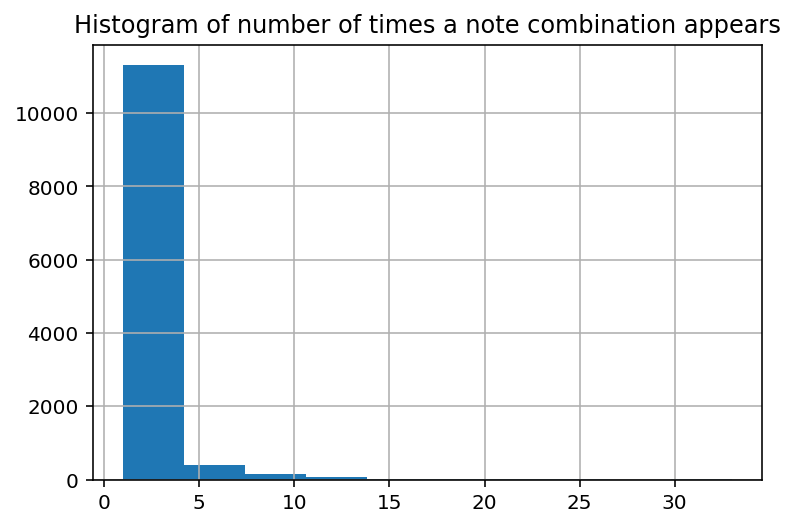

In [382]:
df.drop_duplicates()['count'].hist()
plt.title('Histogram of number of times a note combination appears')

In [14]:
# create mapping of unique chars to integers
chars = sorted(list(set(notes_data)))
char_to_int = dict((c, i) for i, c in enumerate(chars))

In [15]:
n_chars = len(notes_data)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  20267
Total Vocab:  11386


In [16]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = notes_data[i:i + seq_length]
    seq_out = notes_data[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)

Total Patterns:  20167


In [17]:
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

In [410]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [411]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
model.fit(X, y, epochs=20, batch_size=128, callbacks=callbacks_list)

Epoch 1/20
21356/21356 [==============================] - 161s 8ms/step - loss: 9.2011

Epoch 00001: loss improved from 9.38058 to 9.20111, saving model to weights-improvement-01-9.2011.hdf5
Epoch 2/20
21356/21356 [==============================] - 162s 8ms/step - loss: 9.1145

Epoch 00002: loss improved from 9.20111 to 9.11449, saving model to weights-improvement-02-9.1145.hdf5
Epoch 3/20
21356/21356 [==============================] - 164s 8ms/step - loss: 9.0136

Epoch 00003: loss improved from 9.11449 to 9.01358, saving model to weights-improvement-03-9.0136.hdf5
Epoch 4/20
21356/21356 [==============================] - 171s 8ms/step - loss: 8.8606

Epoch 00004: loss improved from 9.01358 to 8.86059, saving model to weights-improvement-04-8.8606.hdf5
Epoch 5/20
21356/21356 [==============================] - 172s 8ms/step - loss: 8.7422

Epoch 00005: loss improved from 8.86059 to 8.74220, saving model to weights-improvement-05-8.7422.hdf5
Epoch 6/20
21356/21356 [=====================

In [18]:
# load the network weights
filename = "weights-improvement-11-7.9671.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

NameError: name 'model' is not defined

In [ ]:
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [421]:
note_sequence = []

# pick a random seed
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
# generate characters
for i in range(1000):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    note_sequence.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print("\nDone.")

Seed:
" 2/3%G#3%E-4%E-50.5%F#3%E-4%E-50.25%F3%E-41/12%F31/6%F3%E40.25%F3%E4%B41/12%F3%E-4%E4%B41/6%F3%E-4%B40.25%F3%E-4%G#41/12%F3%G#45/12%F3%C#4%G#41/12%F3%B3%C#4%G#45/12%F3%B3%G#41/12%F3%G#41/6%F3%C#4%G#40.25%F#3%C#4%B-41/12%F#3%C#4%E-4%B-41/6%F#3%E-4%B-40.5%F3%E-4%B40.25%E-3%E-4%B40.25%E-3%G#3%B40.5%D3%G#3%B40.25%D3%G#3%G#40.25%D3%C#4%G#41.25%D3%C#4%F41/12%D3%F41/6%D3%B3%F40.25%E-3%B3%F#41/12%E-3%B-3%B3%F#41/6%E-3%B-3%F#40.5%D3%B-3%G#40.25%C3%B-3%G#40.25%C3%G#3%G#40.5%B-2%G#3%G#40.5%B-2%G#3%F40.25%B-2%G#3%D41/12%B-2%D45/12%B-2%B-3%D41/12%B-2%B-3%B3%D45/12%B-2%B3%D41/12%B-2%D41/6%B-2%B-3%D40.25%G#2%B-3%D41/12%G#2%G#3%B-3%D41/6%G#2%G#3%D40.25%F#2%G#3%E-41/12%F#2%E-41/6%F#2%F#3%E-40.25%F2%F#3%F41/12%F2%F3%F#3%F41/6%F2%F3%F40.5%E-2%F3%F#40.5%C#3%F3%G40.25%B2%F3%G#41/12%B2%G#41/6%B2%F#3%G#40.25%B-2%F#3%B-41/12%B-2%F#3%G#3%B-41/6%B-2%G#3%B-40.25%G#2%G#3%B41/12%G#2%B41/6%G#2%F#3%B40.25%F#3%C51/12%F3%F#3%C51/6%F3%F#3%C50.25%F3%D51/12%F3%D51/6%E-3%F3%D50.25%E-3%E-51/12%D3%E-3%E-51/6%D3%E-3%E

In [424]:
note_sequence

['0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 'begin',
 'begin',
 'begin',
 'begin',
 'end',
 'end',
 'end',
 'begin',
 '1/12%rest',
 '1/12%rest',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 'begin',
 'begin',
 'begin',
 'begin',
 'begin',
 'begin',
 'begin',
 'begin',
 '1/12%rest',
 '0.25%B3%G4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 'begin',
 'begin',
 'begin',
 'begin',
 'begin',
 'begin',
 'begin',
 'begin',
 '1/12%rest',
 '0.25%B3%G4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F4',
 '0.25%A2%C4%F

In [19]:
notes_to_stream = []
for entry in note_sequence:
    if entry == 'begin' or entry == 'end':
        pass
    
    current_notes = entry.split('%')
    duration = current_notes[0]
    print(duration)
    if current_notes[1] == 'rest':
        notes_to_stream.append(note.Rest(quarterLength=duration))
    else:
        chord_notes = []
        for entry in current_notes[1:]:
            chord_notes.append(note.Note(quarterLength=duration, nameWithOctave=entry))
        notes_to_stream.append(chord.Chord(chord_notes))

midi_stream = stream.Stream(notes_to_stream)
midi_stream.write('midi', fp='test_output.mid')
midi_stream.show()

NameError: name 'note_sequence' is not defined

In [ ]:
midi_stream.show('midi')